In [109]:
import importlib
import os

import pandas as pd
import numpy as np
from tabulate import tabulate   

import config
import module
from tests import test

for p in [config, module, test]:
    try:
        importlib.reload(p)  # reload module
    except NameError:
        pass

In [2]:
cohort_start_date = (
    pd.to_datetime(config.month, format="%Y-%m")
    - pd.Timedelta(days=330)
    - pd.offsets.MonthBegin(1)  # make this the beginning of the month
)
cohort_end_date = (
    pd.to_datetime(config.month, format="%Y-%m")
    + pd.offsets.MonthEnd(0)  # make this the end of the month
)
print(f"cohort start :{cohort_start_date: '%d %b %Y'}, cohort end :{cohort_end_date: '%d %b %Y'}")

cohort start : '01 May 2023', cohort end : '30 Apr 2024'


# Load DF

Load current member DF.

In [3]:
df_member = pd.read_excel(config.path_coco_member)

Load attendance DFs.

In [4]:
date_ranges = module.create_eom_date_ranges("2023-01", config.month)

att_files = [
    os.path.join(
        config.path_attendance_data_parent,
        str(date.year),
        f"{date.year}-{date.month:02}",
        f"data-attendance-{date.year}-{date.month:02}.xlsx",
    )
    for date in date_ranges
]

dfs = []
cols_to_use = ["student_code", "class_date", "student_attendance"]
for file in att_files[-12:]:
    dfs.append(pd.read_excel(file, usecols=cols_to_use))

df_att = pd.concat(dfs, ignore_index=True)
assert len(dfs) == 12

# Clean DF

In [59]:
# the date on which the member join
df_member_clean = (
    df_member
    .assign(
        student_code=lambda df_: df_["student_code"].str.upper(),
        is_first=True, 
        start_month=lambda df_:pd.to_datetime(df_["start_date"].dt.strftime(f"%Y-%m-01")),
        class_date=lambda df_:df_["start_date"],
    )
    # loc date between cohort start and end
    .loc[
        lambda df_: (df_["start_date"] >= cohort_start_date)
        & (df_["start_date"] <= cohort_end_date),
        ["class_date", "student_code", "start_date", "start_month", "student_membership"],
    ]
    .sort_values("start_date", ignore_index=True)
)
print(tabulate(df_member_clean.head(), headers="keys"))
print(tabulate(df_member_clean.tail(), headers="keys"))

    class_date           student_code    start_date           start_month          student_membership
--  -------------------  --------------  -------------------  -------------------  --------------------
 0  2023-05-01 00:00:00  DELUXE 9528     2023-05-01 00:00:00  2023-05-01 00:00:00  Deluxe
 1  2023-05-01 00:00:00  GO 3366         2023-05-01 00:00:00  2023-05-01 00:00:00  Go
 2  2023-05-01 00:00:00  VIP 7947        2023-05-01 00:00:00  2023-05-01 00:00:00  VIP
 3  2023-05-01 00:00:00  DELUXE 9524     2023-05-01 00:00:00  2023-05-01 00:00:00  Deluxe
 4  2023-05-01 00:00:00  GO 3337         2023-05-01 00:00:00  2023-05-01 00:00:00  Go
      class_date           student_code    start_date           start_month          student_membership
----  -------------------  --------------  -------------------  -------------------  --------------------
2858  2024-04-30 00:00:00  GO 4463         2024-04-30 00:00:00  2024-04-01 00:00:00  Go
2859  2024-04-30 00:00:00  DELUXE 11198    2024-04-30 00:

In [60]:
# attendance of all member
df_att_clean = (
    df_att
    .loc[lambda df_: df_["student_attendance"] == "Attend"]  # only attend
    .drop(columns=["student_attendance"])
    # uppercase code
    .assign(
        student_code=lambda df_: df_["student_code"].str.upper(),
    )
    # loc attendance between cohort start and end
    .loc[
        lambda df_: (df_["class_date"] >= cohort_start_date)
        & (df_["class_date"] <= cohort_end_date)
    ]
    # only include members who are in df_member_clean
    # else, old members who started before that will be in the data
    .loc[lambda df_: df_["student_code"].isin(
        df_member_clean["student_code"].unique()
    )]
)
df_att_clean.head()

,class_date,student_code
50,2023-05-01,VIP 7947
104,2023-05-01,GO 3337
197,2023-05-01,DELUXE 8107
205,2023-05-01,GO 728
227,2023-05-01,DELUXE 7608
...,...,...
230696,2024-04-30,GO 4123
230697,2024-04-30,GO 4279
230701,2024-04-30,VIP 10761
230702,2024-04-30,VIP 10932


# Create cohort

In [116]:
def make_cohort(df_member, df_att, membership=None): 

    # make bins of 30-day interval
    bins = pd.IntervalIndex.from_tuples([(i + 1, i + 30) for i in range(0, 360, 30)], closed="both")

    # concat 2 DFs and fill dates
    result = (pd.concat([df_member, df_att])
        # fill the start date of each attendance
        .sort_values(["student_code", "start_date"])
        .assign(
            start_date=lambda df_: df_["start_date"].ffill(),
            start_month=lambda df_: df_["start_month"].ffill(),
            student_membership=lambda df_: df_["student_membership"].ffill(),
        )
    )

    # if membership is specified, filter based on membership
    if membership:
        result = result.loc[result["student_membership"] == membership]

    # make cohort
    result = (
        result
        # remove classes where class date BEFORE start date
        # these are mainly repurchases
        .loc[lambda df_: ~(df_["class_date"] < df_["start_date"])]
        # create bin
        .assign(
            startdate_to_classdate=lambda df_: (df_["class_date"] - df_["start_date"]).dt.days + 1,
            startdate_to_classdate_bin=lambda df_: pd.cut(df_["startdate_to_classdate"], bins=bins)
        )
        # group by start_month then bin
        .groupby(["start_month", "startdate_to_classdate_bin"])
        .agg(count=("student_code", "nunique"))
        # normalize the count relative to first month
        .reset_index()
        .assign(
            perc=lambda df_: (df_["count"].div(df_.groupby(["start_month"], observed=True)["count"].transform("max")))
        )
        # pivot 
        .pivot(
            index="start_month", 
            columns="startdate_to_classdate_bin", 
            values="perc"
        )
        .rename(index=lambda i: i.strftime("%b %Y"))
    )

    # delete bottom right diagonal
    cohort_arr = result.values
    rows, cols = cohort_arr.shape
    for i in range(rows):
        for j in range(cols):
            if j > cols - i - 1:
                result.iloc[i, j] = np.nan
          
    # create average row
    result = (result
        .transpose()
        .assign(Average=lambda df_: df_.mean(axis="columns"))          
        .transpose()
    )

    return result

make_cohort(df_member_clean, df_att_clean)

/tmp/ipykernel_525508/3098632558.py:33: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["start_month", "startdate_to_classdate_bin"])


startdate_to_classdate_bin,"[1, 30]","[31, 60]","[61, 90]","[91, 120]","[121, 150]","[151, 180]","[181, 210]","[211, 240]","[241, 270]","[271, 300]","[301, 330]","[331, 360]"
start_month,,,,,,,,,,,,
May 2023,1.0,0.826367,0.739550,0.668810,0.585209,0.565916,0.508039,0.504823,0.482315,0.430868,0.379421,0.302251
Jun 2023,1.0,0.771863,0.676806,0.634981,0.547529,0.543726,0.517110,0.463878,0.403042,0.349810,0.250951,NaN
Jul 2023,1.0,0.673780,0.603659,0.548780,0.493902,0.457317,0.460366,0.420732,0.365854,0.253049,NaN,NaN
Aug 2023,1.0,0.715210,0.656958,0.614887,0.566343,0.566343,0.478964,0.401294,0.317152,NaN,NaN,NaN
Sep 2023,1.0,0.706081,0.604730,0.554054,0.520270,0.442568,0.405405,0.310811,NaN,NaN,NaN,NaN
Oct 2023,1.0,0.834008,0.696356,0.688259,0.615385,0.554656,0.433198,NaN,NaN,NaN,NaN,NaN
Nov 2023,1.0,0.765027,0.704918,0.644809,0.540984,0.398907,NaN,NaN,NaN,NaN,NaN,NaN
Dec 2023,1.0,0.712575,0.568862,0.532934,0.377246,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Jan 2024,1.0,0.734694,0.632653,0.440816,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


/tmp/ipykernel_525508/3098632558.py:33: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["start_month", "startdate_to_classdate_bin"])


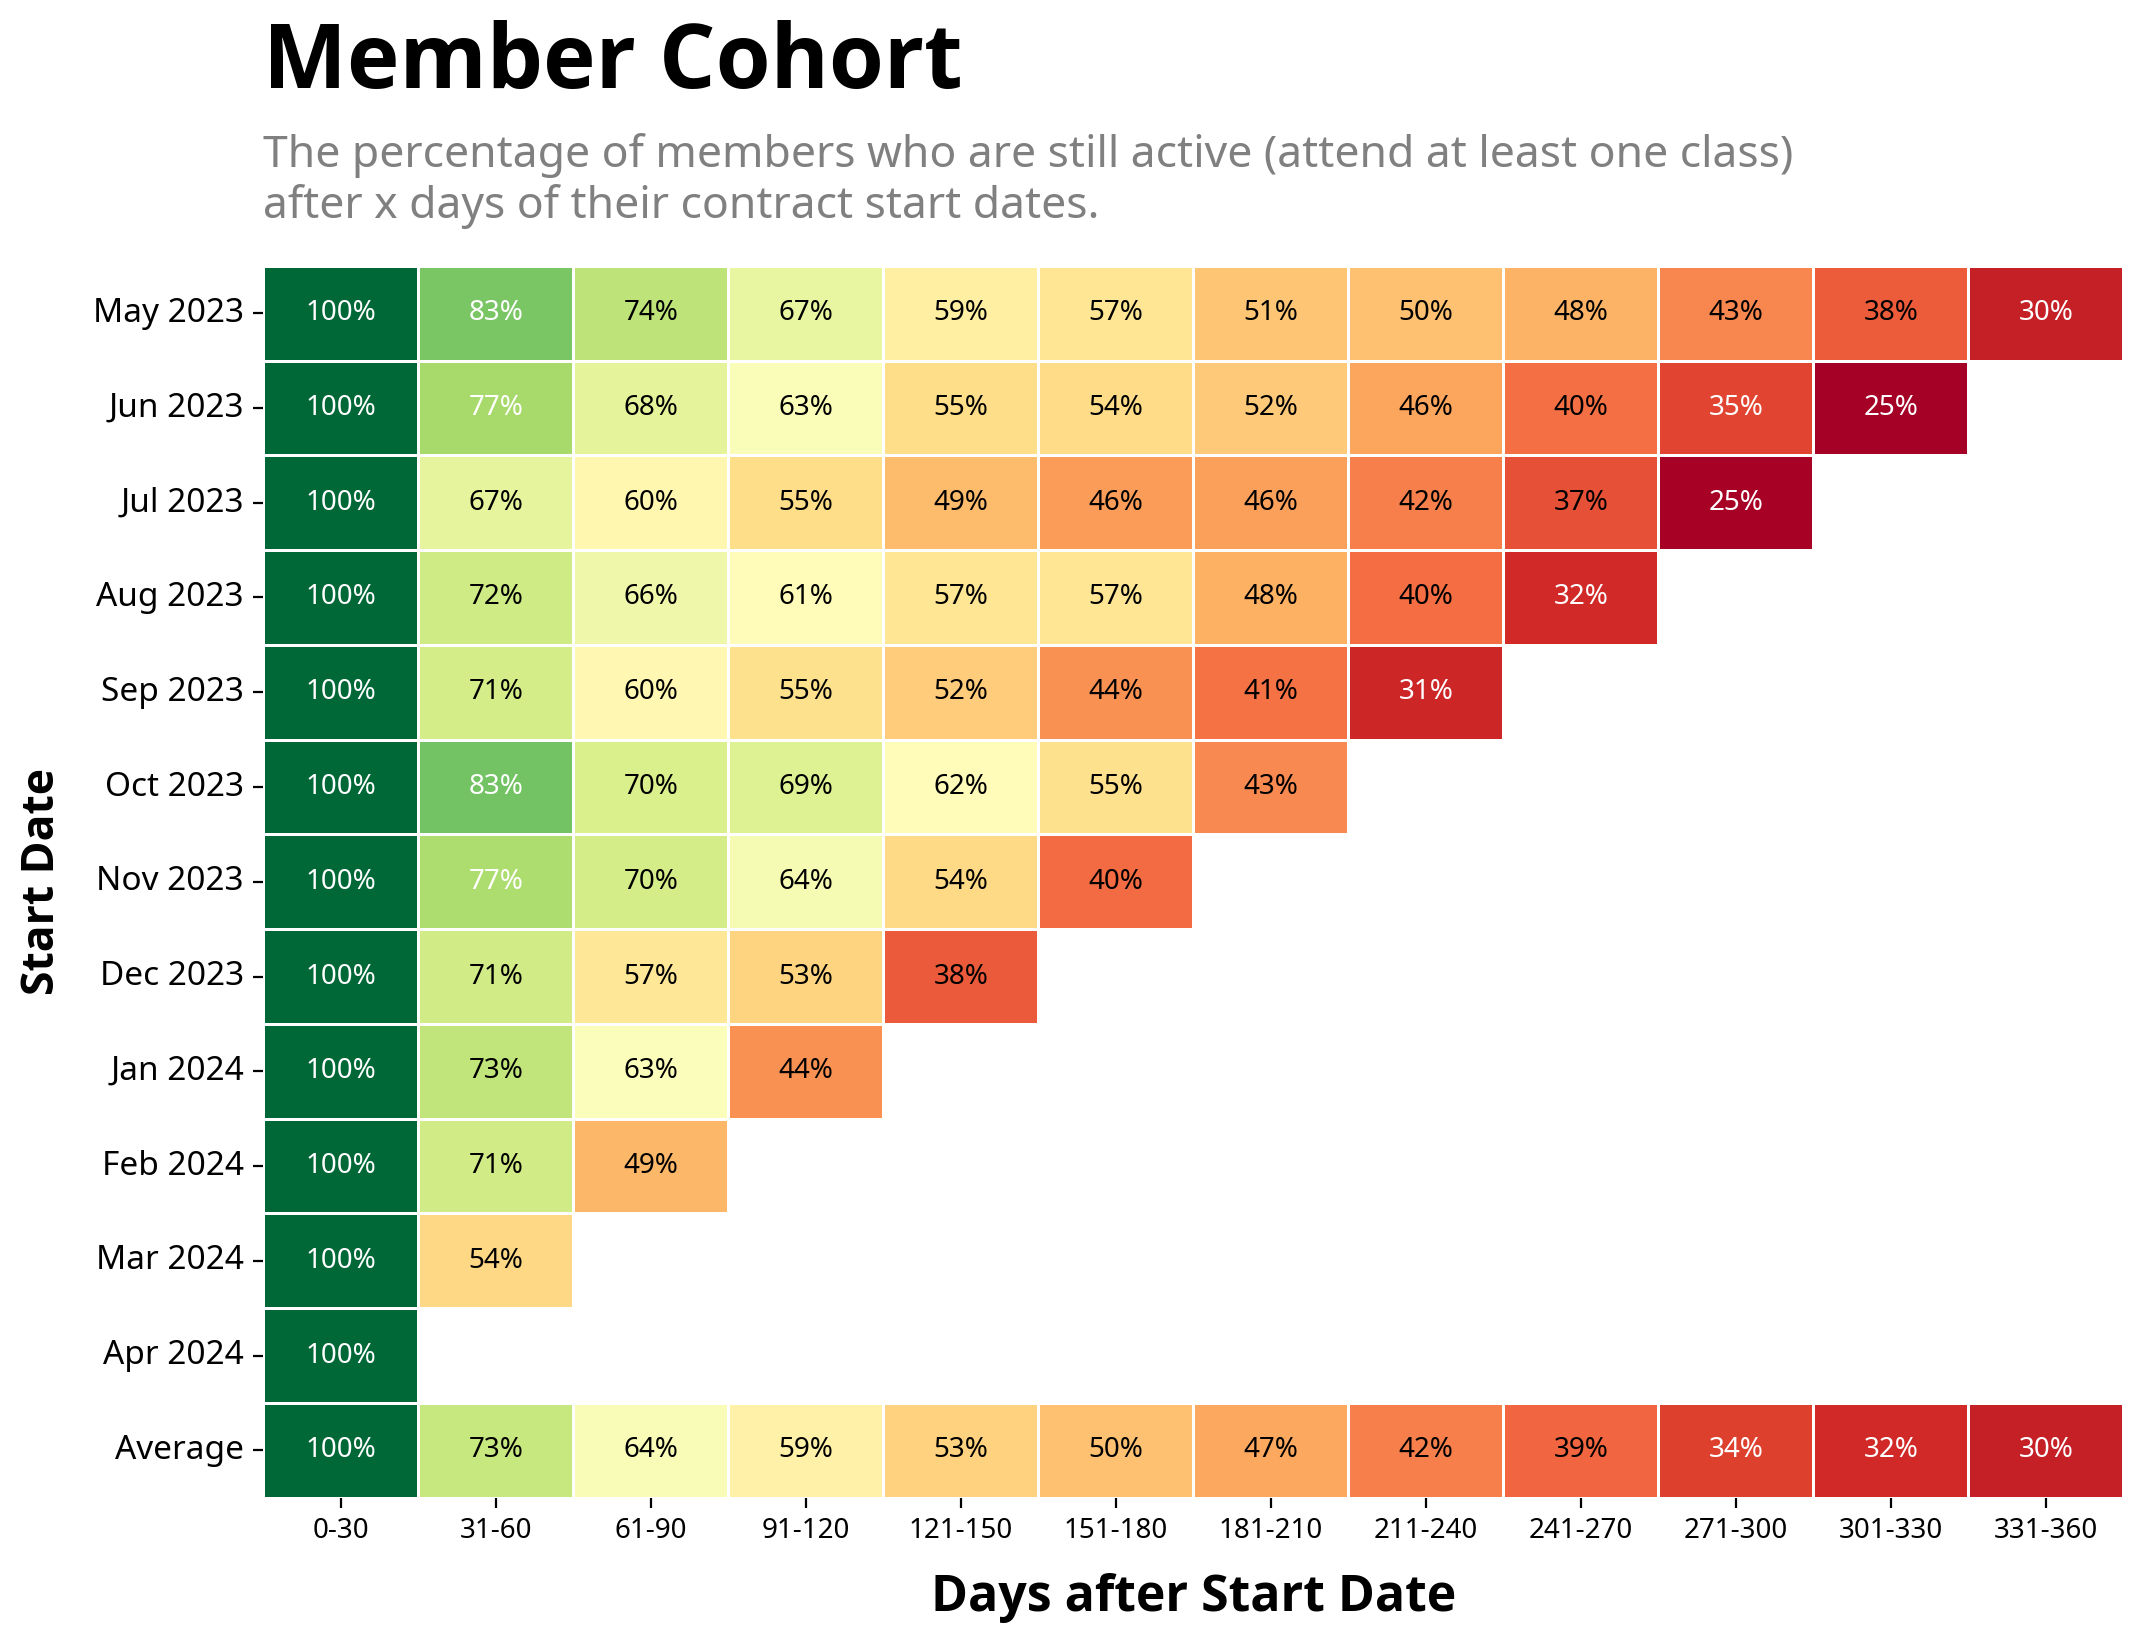

/tmp/ipykernel_525508/3098632558.py:33: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["start_month", "startdate_to_classdate_bin"])


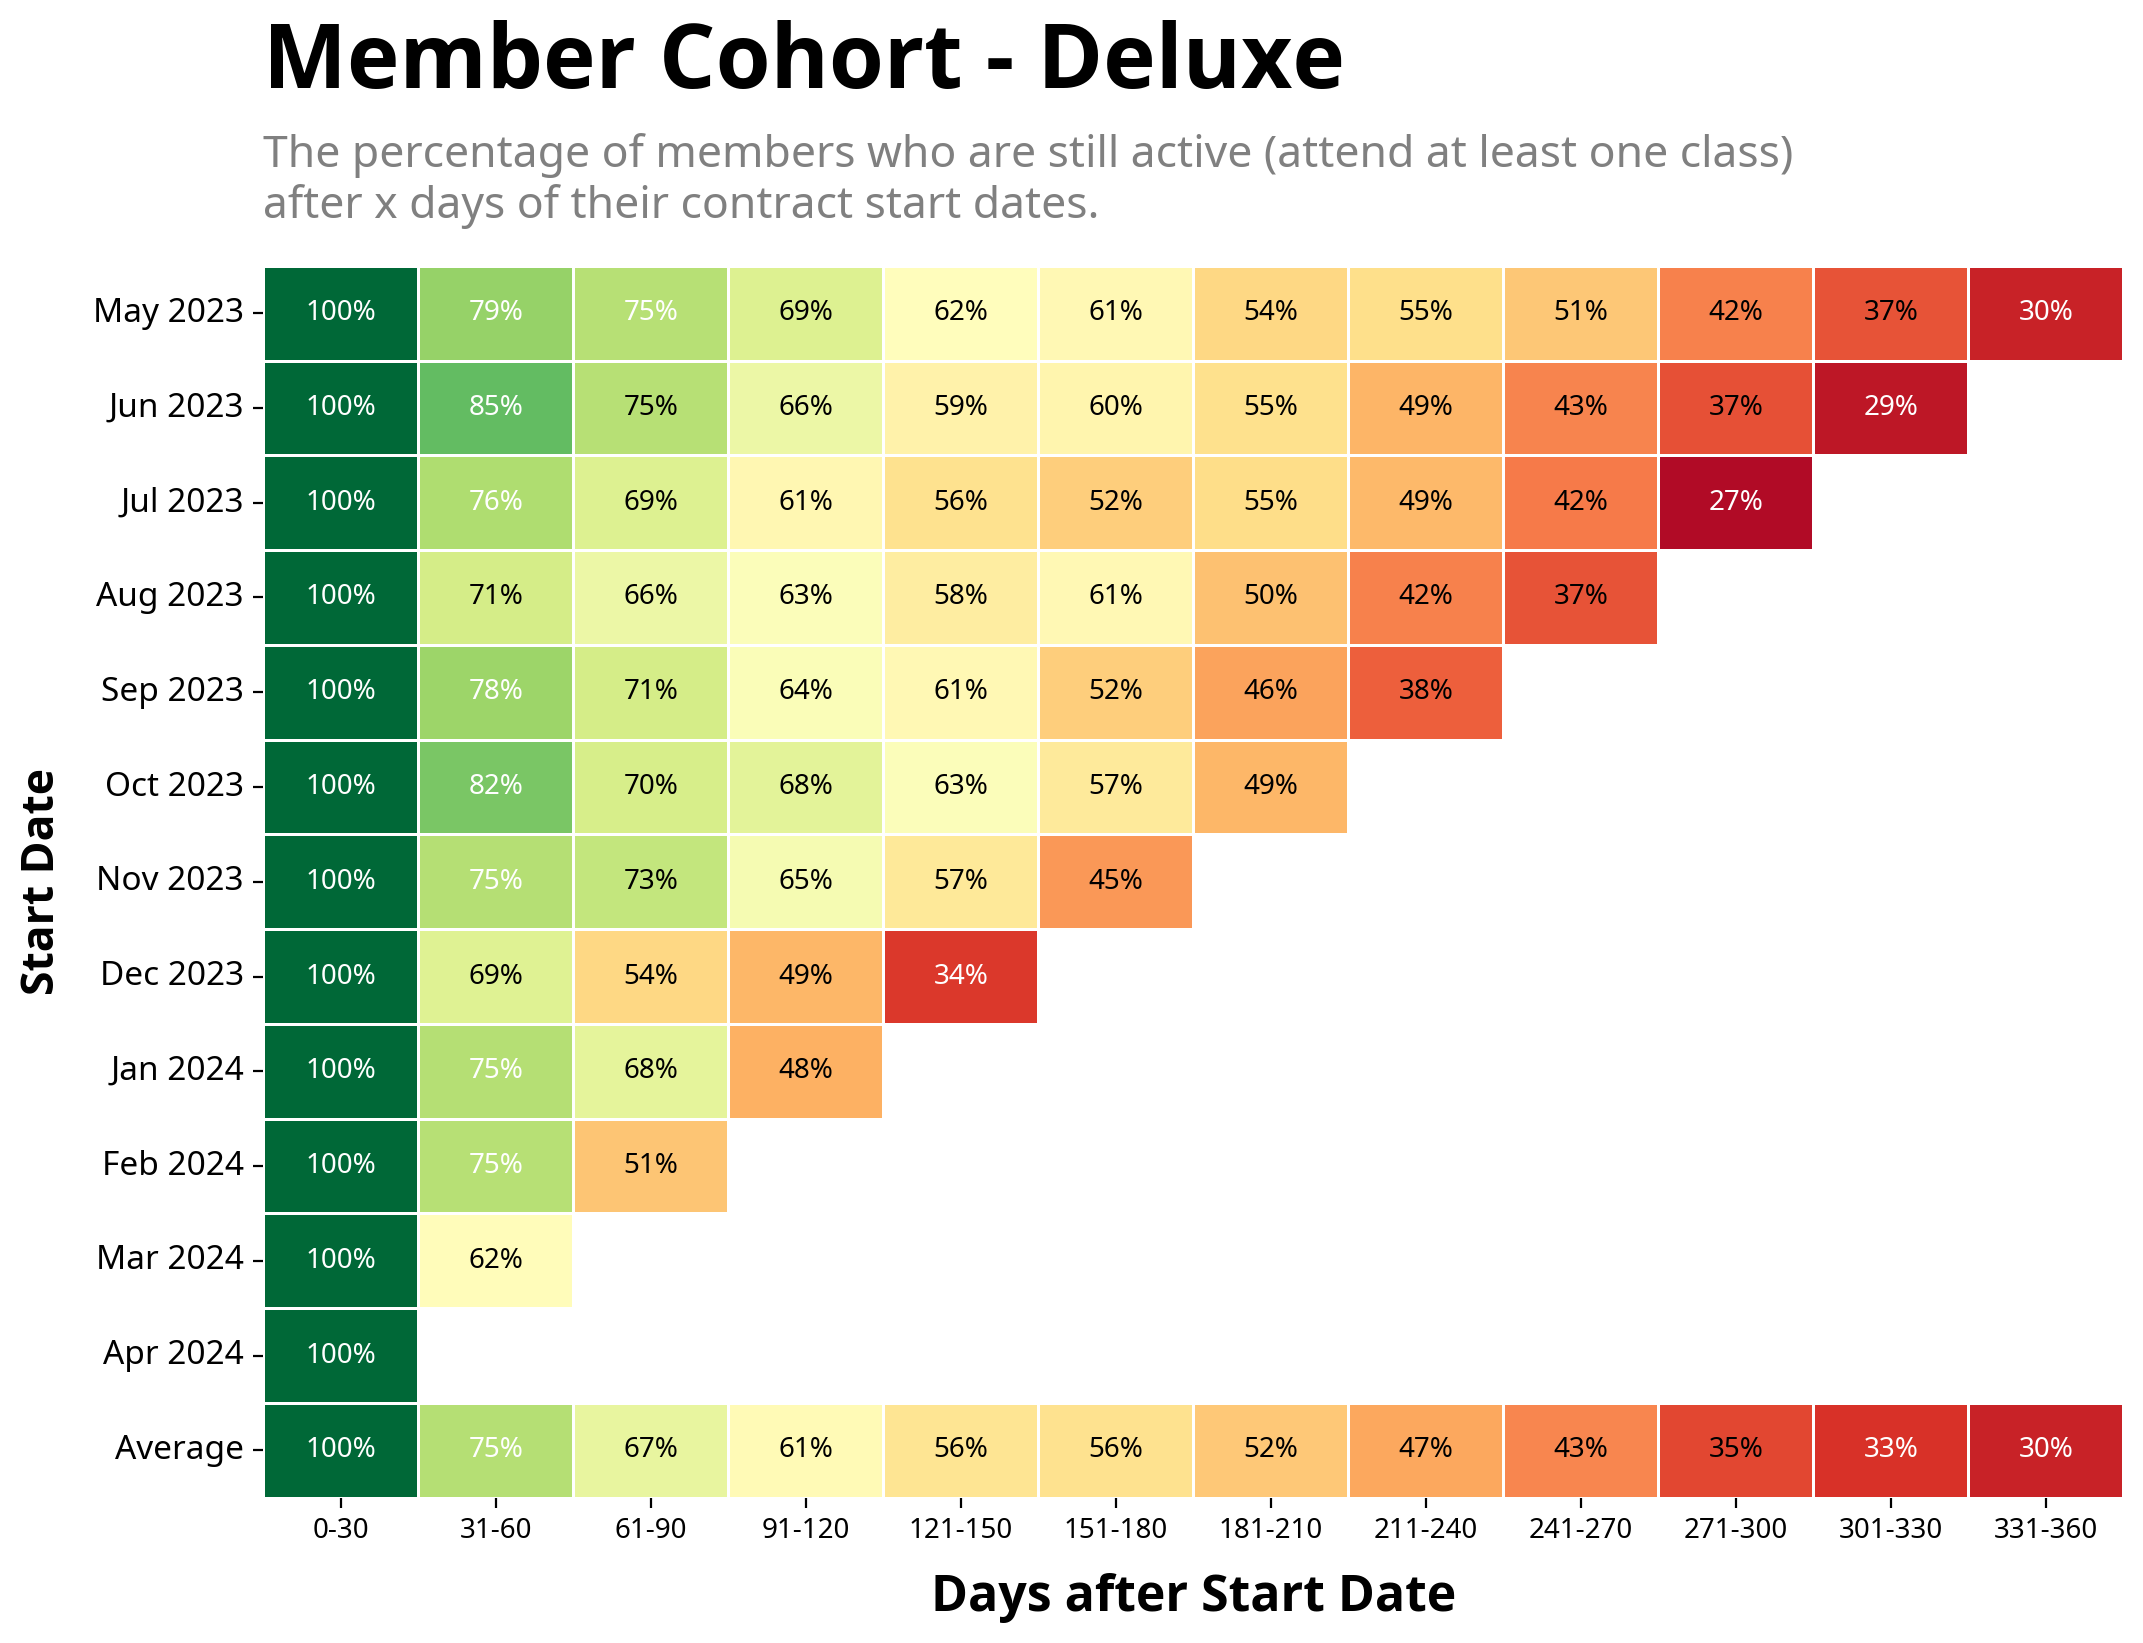

/tmp/ipykernel_525508/3098632558.py:33: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["start_month", "startdate_to_classdate_bin"])


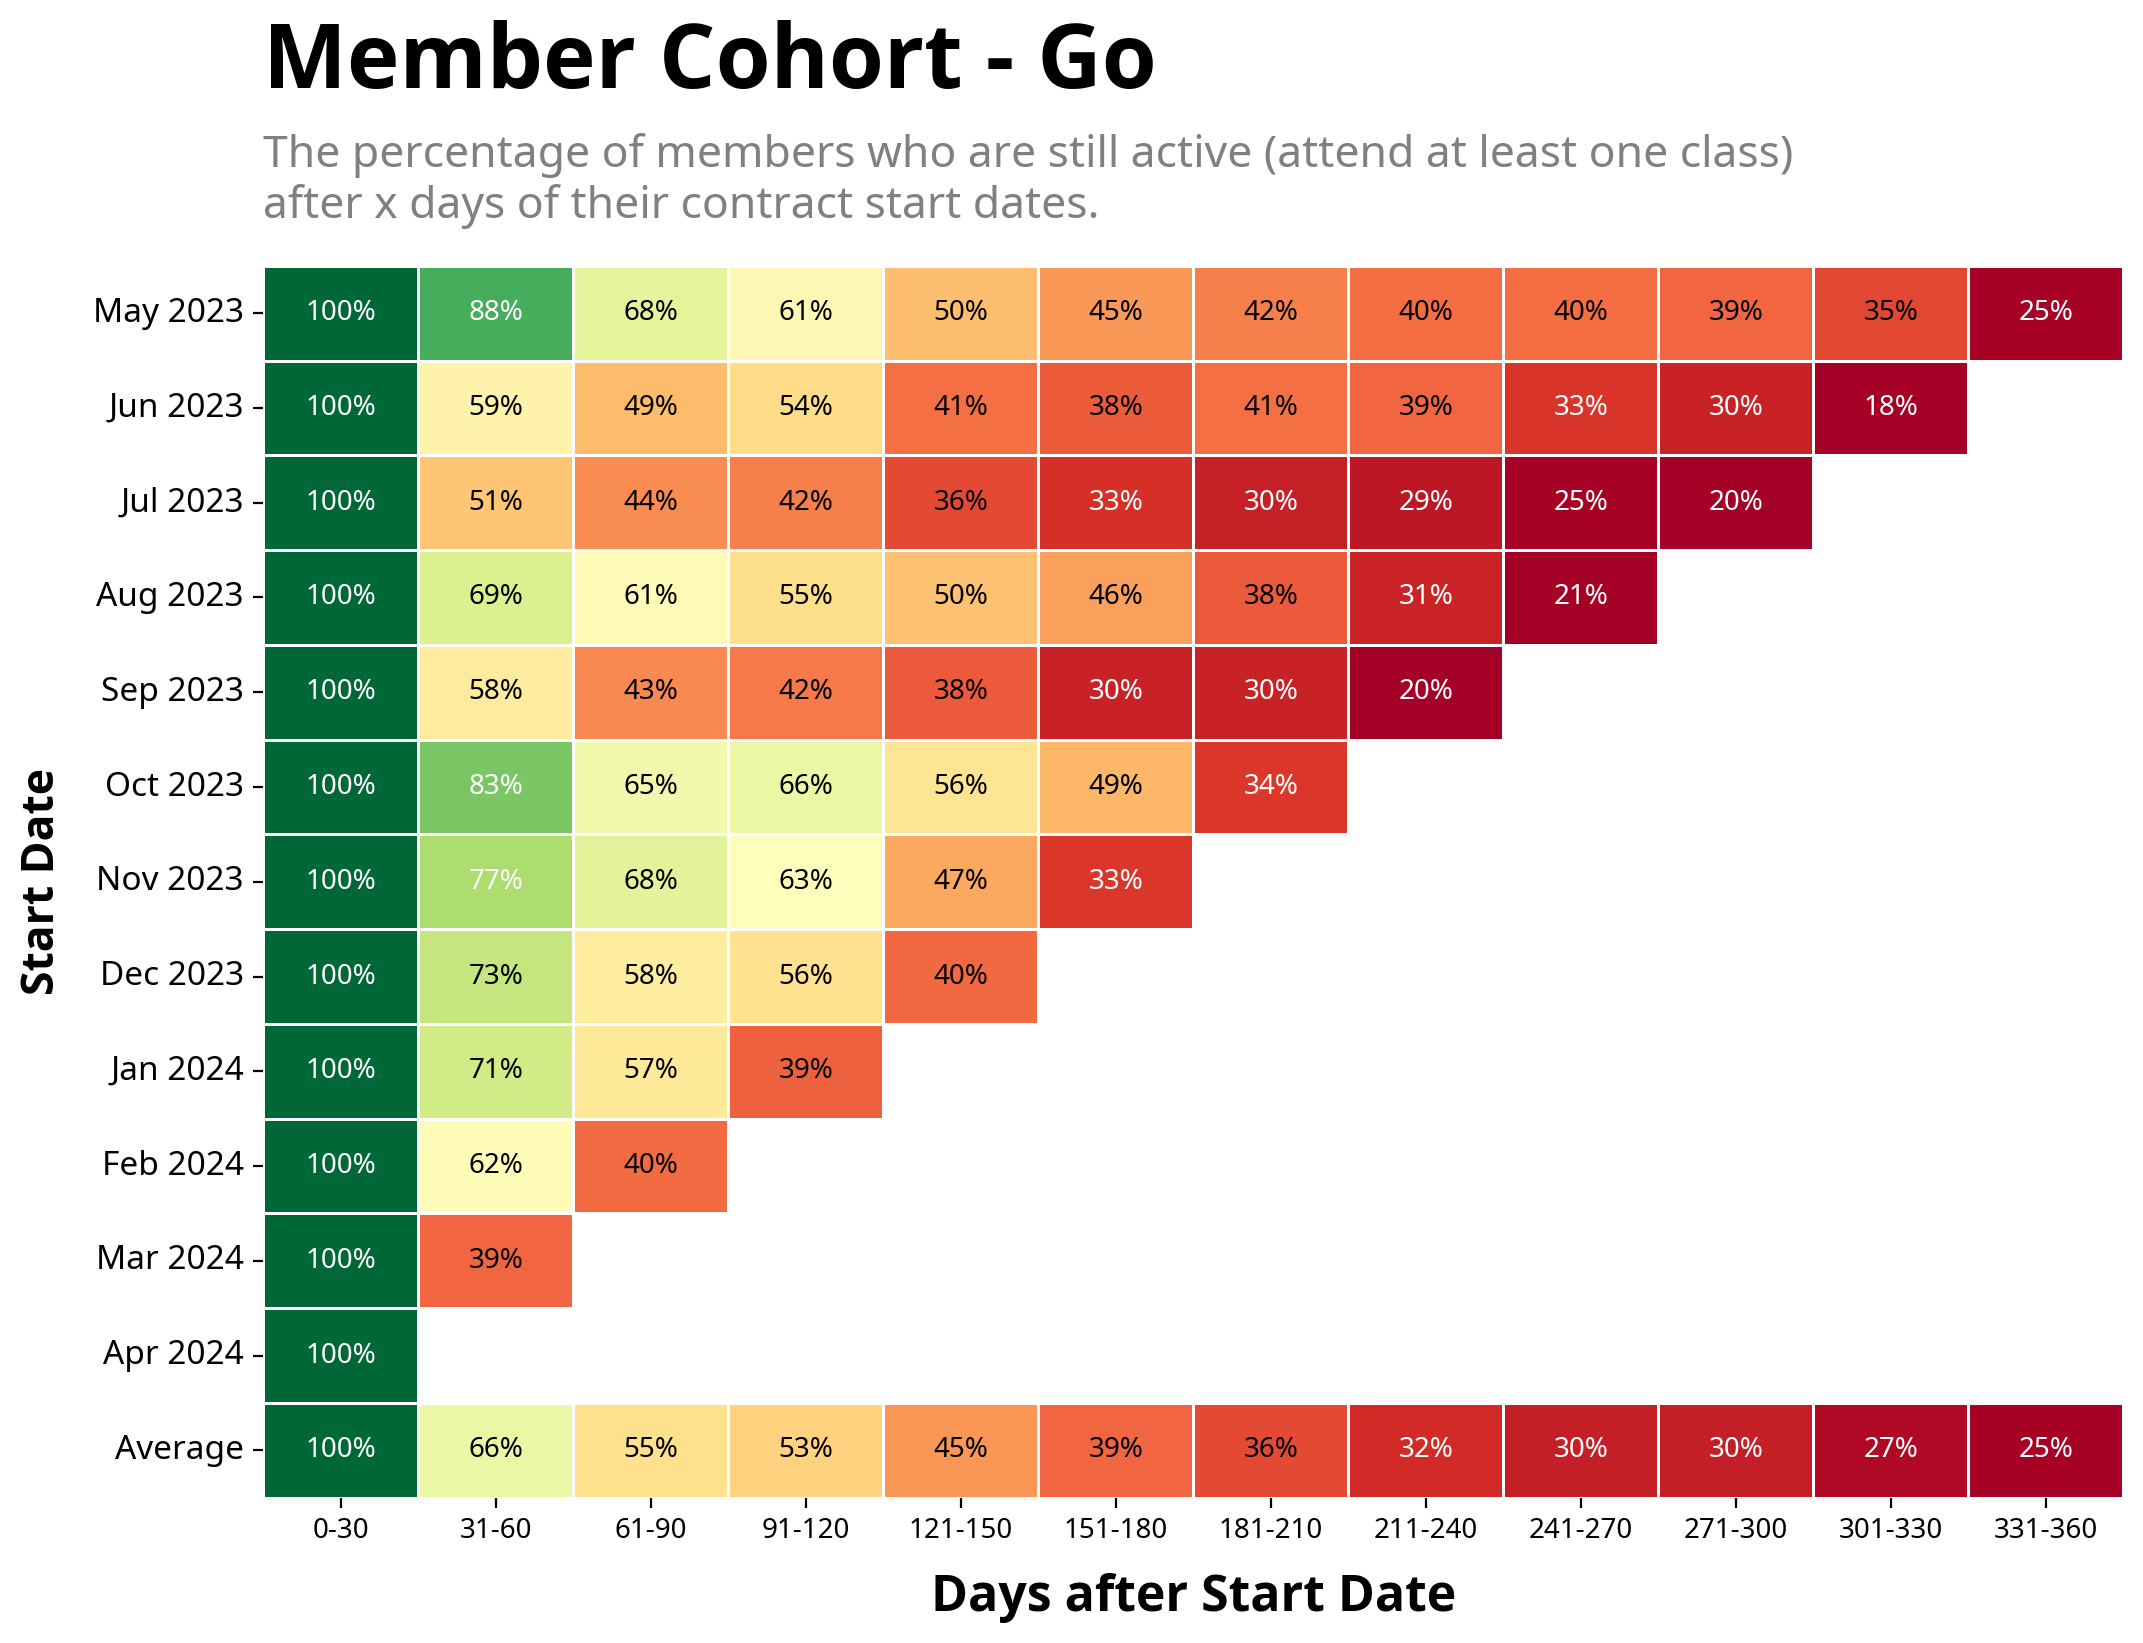

/tmp/ipykernel_525508/3098632558.py:33: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["start_month", "startdate_to_classdate_bin"])


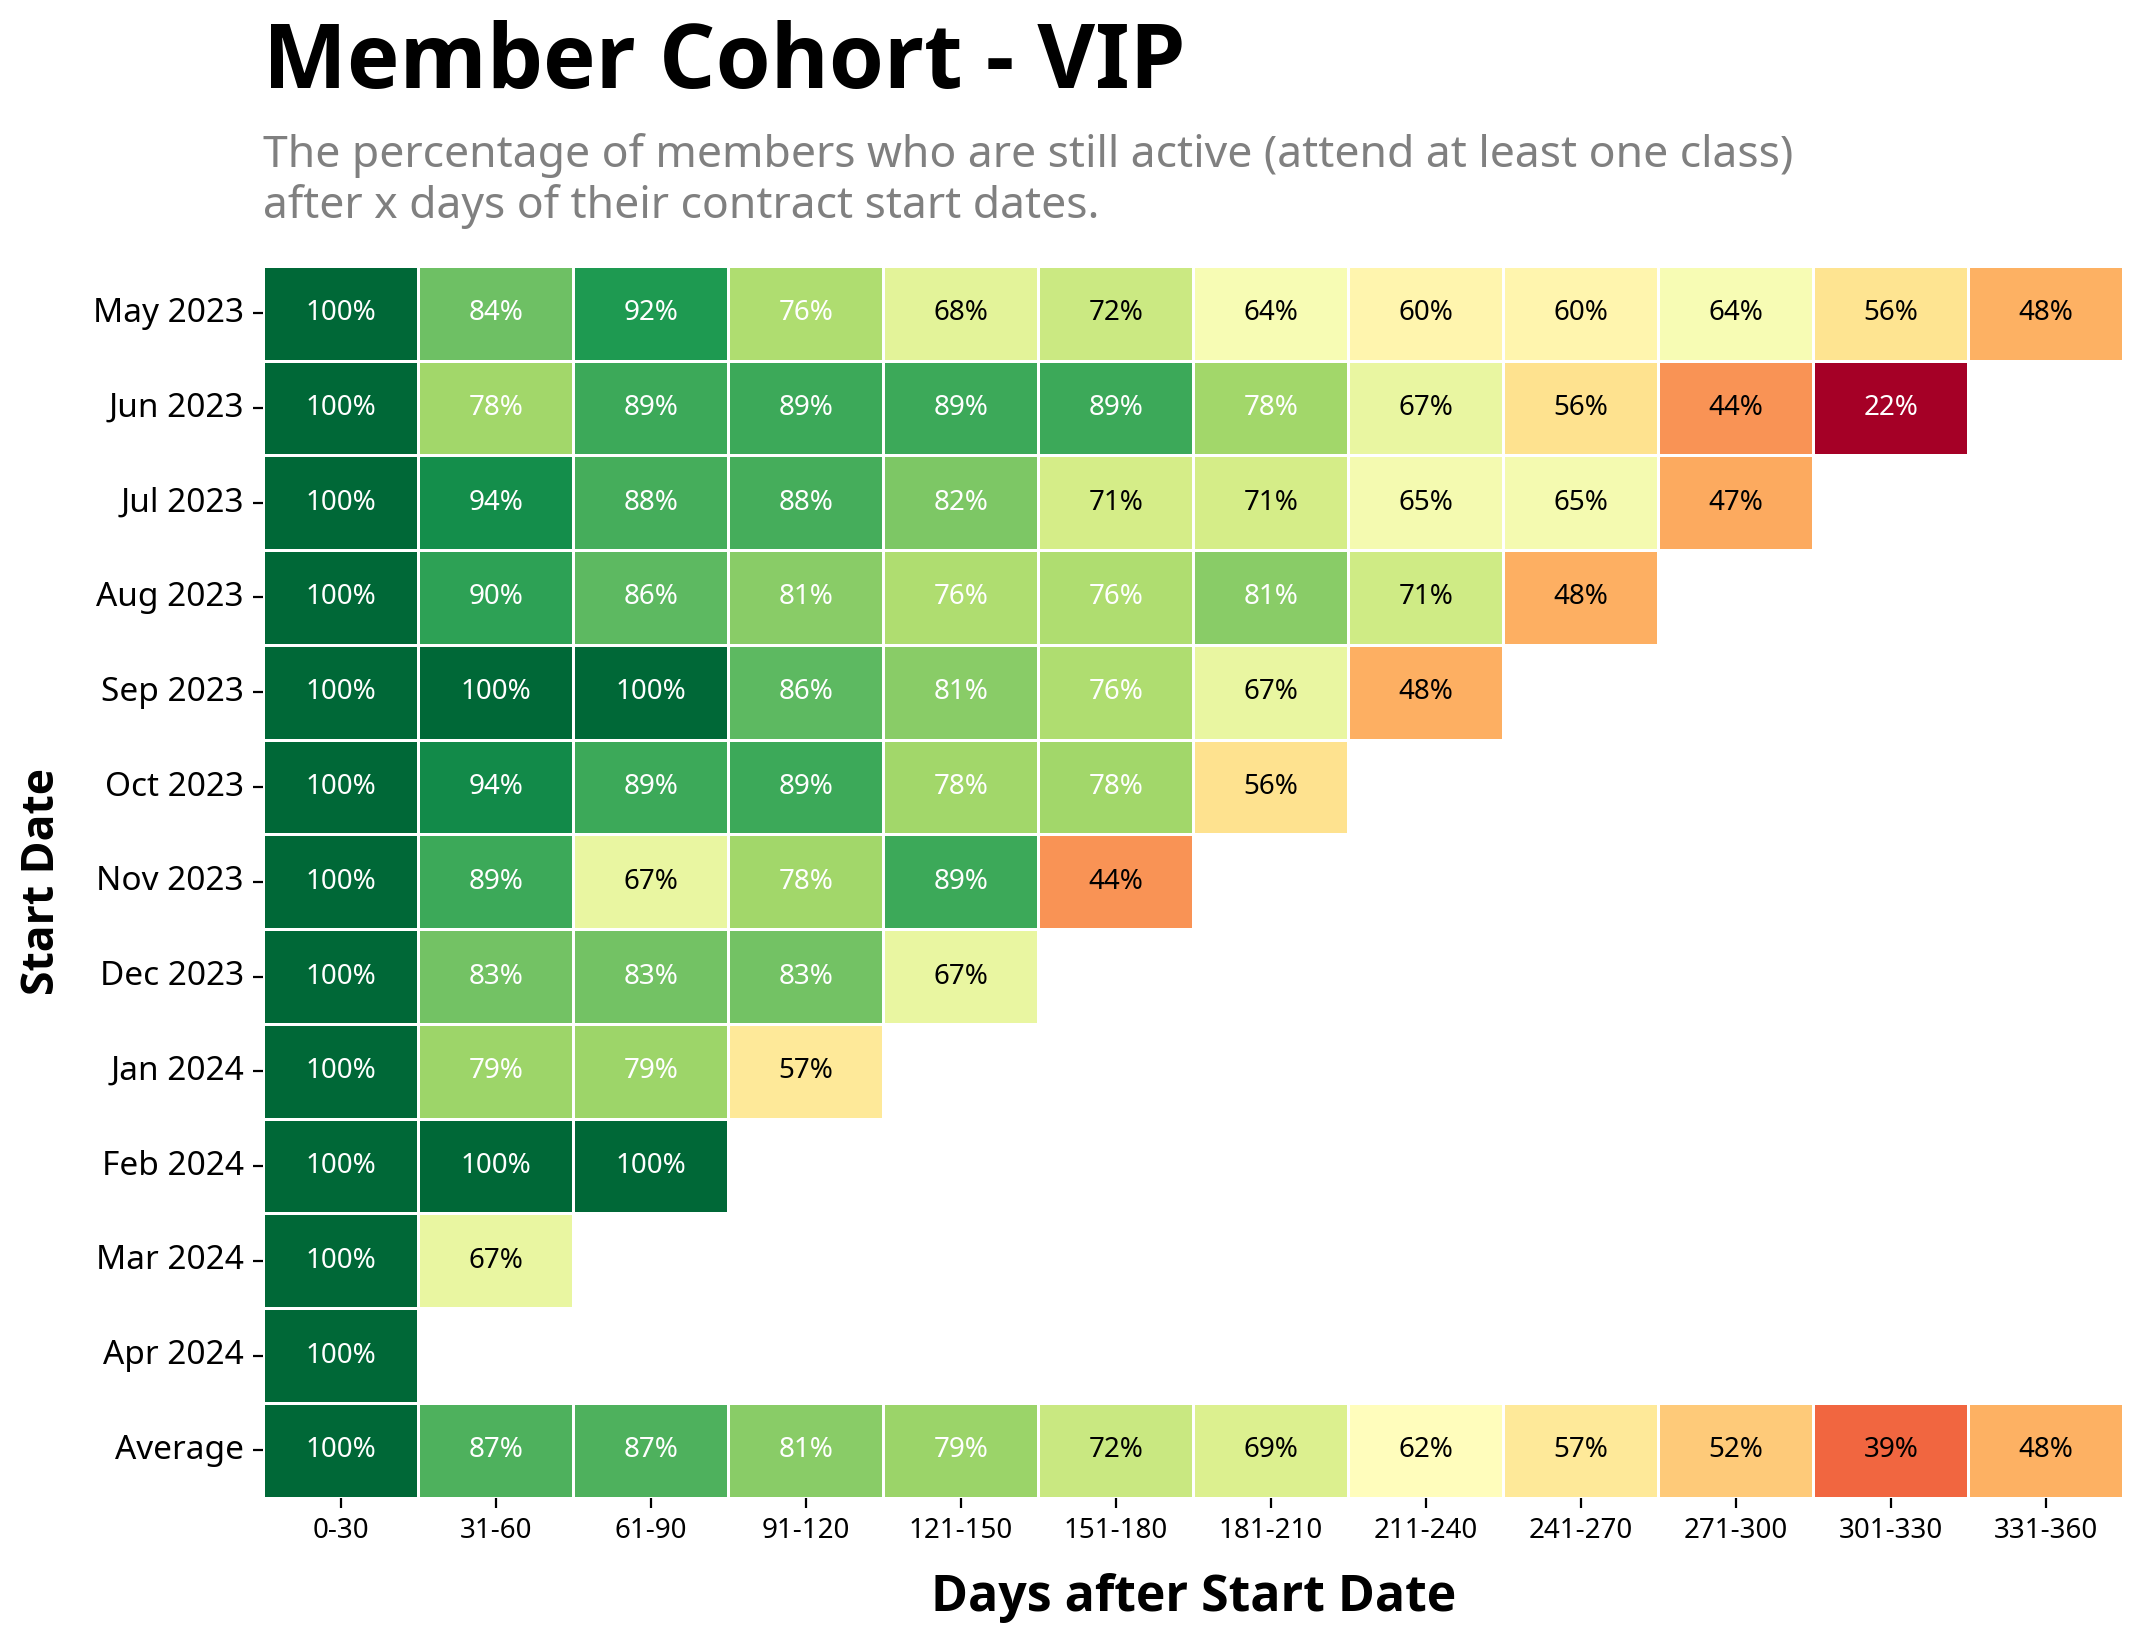

In [118]:
for p in [config, module, test]:
    try:
        importlib.reload(p)  # reload module
    except NameError:
        pass

module.plot_cohort(make_cohort(df_member_clean, df_att_clean), title=f"Member Cohort")
for membership in ["Deluxe", "Go", "VIP"]:
    df_cohort = make_cohort(df_member_clean, df_att_clean, membership)
    module.plot_cohort(df_cohort, title=f"Member Cohort - {membership}")